# Final Project  
# Transfer Learning: Fruits 360 with ResNet34

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  Fruits 360
**Description:** this notebook uses the MNIST database to perform a supervised learning with the aim of image classification of handwritten digits.  
**Download:** https://www.kaggle.com/moltean/fruits/download


## 1. Libraries and packages

In [0]:
!pip install -q \
    numpy       \
    torch       \
    sklearn     \
    skorch      \
    matplotlib  

In [0]:
#-------------------------------------------------
# general
#-------------------
import pandas as pd
import numpy as np
import glob
from PIL import Image
from os import listdir
#-------------------------------------------------
# PyTorch
#-------------------
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
#from torchvision.utils import make_grid
#-------------------------------------------------
# skorch
#-------------------
#from skorch.dataset import CVSplit
#-------------------------------------------------
# scikit-learn
#-------------------
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython import display
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
torch.manual_seed(42);

### Check if GPU is available

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('GPU available:', device)

GPU available: cuda


## 2. Dataset loading

### 2.1 Mounting and unzipping dataset in Google Drive

In [4]:
# mounting
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# unzipping
!unzip -q -n "/gdrive/Shared drives/Drive compartilhado EA999/fruits.zip"

### 2.2 Transforms

### Resize

In [0]:
class Resize(object):
    def __init__(self, output_size):
        self.output_size = output_size
    def __call__(self, data):
        im = Image.Image()
        image = data.resize(self.output_size)
        return image

### ImageNet transforms

In [0]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

### Compose

In [0]:
# transforms
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()
#-------------------------------------------------
resize_image = Resize(output_size=(224,224))
#-------------------------------------------------
compose_transform = [
    resize_image,
    pil2tensor,
    normalize,
]
#-------------------------------------------------
fruits_transforms = transforms.Compose(compose_transform)

### 2.3 PyTorch dataset creation

In [0]:
rootdir = 'fruits-360_dataset/fruits-360/'
train_path = rootdir + '/Training/'
test_path = rootdir + '/Test/'
#ds_train = ImageFolder(train_path, transform=transforms.ToTensor())
#ds_test = ImageFolder(test_path, transform=transforms.ToTensor())
ds_train = ImageFolder(train_path, transform=fruits_transforms)
ds_test = ImageFolder(test_path, transform=fruits_transforms)

In [10]:
print(ds_train)

Dataset ImageFolder
    Number of datapoints: 60498
    Root location: fruits-360_dataset/fruits-360//Training/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [11]:
print(ds_test)

Dataset ImageFolder
    Number of datapoints: 20622
    Root location: fruits-360_dataset/fruits-360//Test/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## 3. Network Model

In [0]:
N_SAMPLES = len(ds_train)
#V_SAMPLES = len(ds_val)
V_SAMPLES = len(ds_test)
N_CLASSES = len(glob.glob('fruits-360_dataset/fruits-360/Training/*'))

### Base network: ResNet34

In [0]:
# importing the model
import torchvision.models as models
resnet34 = models.resnet34(pretrained=True)
#-------------------
# freeze all weights
for param in resnet34.parameters():
    param.requires_grad = False

### Modifying ResNet's last layer

In [14]:
resnet34.fc = torch.nn.Identity(in_features=512, out_features=N_CLASSES)
resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Network training predict

In [0]:
x = torch.zeros(N_SAMPLES, 512, dtype=torch.float32)
y = torch.zeros(N_SAMPLES, dtype=torch.int64)

In [0]:
# Adjust BATCH_SIZE to do the prediction
PREDICTION_BATCH = 1000
#-------------------
# DataLoader for training set
dl_train = DataLoader(
    ds_train, 
    batch_size=PREDICTION_BATCH,
    drop_last = False,
    shuffle = True)

In [17]:
# evaluation mode
resnet34.eval()
# create "new dataset"
for b_i, (b_x, b_y) in enumerate(dl_train):
    b_x, b_y = b_x.to(device), b_y.to(device)
    x[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,] = resnet34(b_x)
    y[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,] = b_y
    print(b_i, b_x.shape, b_y.shape, x[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,].shape, y[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,].shape)

0 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
1 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
2 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
3 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
4 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
5 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
6 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
7 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
8 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
9 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
10 torch.Size([1000, 3, 224, 224]) torch

Save ResNet34 training logitos in a file

In [0]:
# Save ResNet34 logitos in a file
torch.save(x, 'logitos_x_train.pt')
torch.save(y, 'logitos_y_train.pt')

Restore ResNet34 training logitos from file

In [0]:
# # Load ResNet34 logitos from file
# x = torch.load('logitos_x_train.pt')
# y = torch.load('logitos_y_train.pt')

### Network validation predict

In [0]:
xval = torch.zeros(V_SAMPLES, 512, dtype=torch.float32)
yval = torch.zeros(V_SAMPLES, dtype=torch.int64)

In [0]:
# Adjust BATCH_SIZE to do the prediction
PREDICTION_BATCH = 1000
#-------------------
# # DataLoader for validation set
# dl_val = DataLoader(
#     ds_val, 
#     batch_size=PREDICTION_BATCH,
#     drop_last = False,
#     shuffle = False)
#-------------------
# DataLoader for test set
dl_test = DataLoader(
    ds_test, 
    batch_size=PREDICTION_BATCH,
    drop_last = False,
    shuffle = True)

In [22]:
# evaluation mode
resnet34.eval()
# create "new dataset"
for b_i, (b_x, b_y) in enumerate(dl_test):
    b_x, b_y = b_x.to(device), b_y.to(device)
    xval[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,] = resnet34(b_x)
    yval[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,] = b_y
    print(b_i, b_x.shape, b_y.shape, xval[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,].shape, yval[b_i*PREDICTION_BATCH:(b_i+1)*PREDICTION_BATCH,].shape)

0 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
1 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
2 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
3 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
4 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
5 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
6 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
7 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
8 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
9 torch.Size([1000, 3, 224, 224]) torch.Size([1000]) torch.Size([1000, 512]) torch.Size([1000])
10 torch.Size([1000, 3, 224, 224]) torch

Save ResNet34 test logitos in a file

In [0]:
# Save ResNet34 logitos in a file
torch.save(xval, 'logitos_x_test.pt')
torch.save(yval, 'logitos_y_test.pt')

Restore ResNet34 test logitos from file

In [0]:
# # Load ResNet34 logitos from file
# xval = torch.load('logitos_x_test.pt')
# yval = torch.load('logitos_y_test.pt')

### Create "new" Dataset with ResNet34 logitos

In [0]:
ds_transformed_train = TensorDataset(x, y)
ds_transformed_valid = TensorDataset(xval, yval)

### Creating Dataloader for training

In [0]:
BATCH_SIZE = 1000

In [0]:
# DataLoader for training set
dl_transformed_train = DataLoader(
    ds_transformed_train, 
    batch_size = BATCH_SIZE,
    drop_last = False,
    shuffle = True)

In [0]:
# DataLoader for validation set
dl_transformed_val = DataLoader(
    ds_transformed_valid, 
    batch_size = BATCH_SIZE,
    drop_last = False,
    shuffle = True)

## 4. Network training

### Training only last layer

In [0]:
class FC(torch.nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc = torch.nn.Linear(in_features=512, out_features=N_CLASSES)
    def forward(self, x):
        return self.fc(x)

### 4.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
model = FC()
model.to(device)
# Training parameters
EPOCH = 1000
LR = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
# loss history
loss_his = []
loss_val_his = []

### 4.2 Training loop

In [31]:
for epoch in range(EPOCH):
    print('epoch =', epoch, end='; ')
    #-------------------------------------------------
    # training
    model.train()
    zero_one_loss = 0.
    for b_i, (b_x, b_y) in enumerate(dl_transformed_train):   # for each training step
        b_x, b_y = b_x.to(device), b_y.to(device)
        y_logitos = model(b_x)
        loss = loss_func(y_logitos, b_y)
        opt.zero_grad()                 # clear gradients for next train
        loss.backward()                 # backpropagation, compute gradients
        opt.step()                      # apply gradients
        #-------------------
        y_pred = torch.argmax(y_logitos, dim=1)
        zero_one_loss += (b_y == y_pred).sum()
    acc_train = zero_one_loss / N_SAMPLES
    #-------------------------------------------------
    # validation
    model.eval()
    zero_one_loss_val = 0.
    for b_ival, (b_xval, b_yval) in enumerate(dl_transformed_val):
        b_xval, b_yval = b_xval.to(device), b_yval.to(device)
        y_logitos = model(b_xval)
        loss_val = loss_func(y_logitos, b_yval)
        yval_pred = torch.argmax(y_logitos, dim=1)
        zero_one_loss_val += (b_yval == yval_pred).sum()
    #-------------------------------------------------
    loss_his.append(loss.item())    # loss recoder
    loss_val_his.append(loss_val.item())    # loss recoder
    acc_val = zero_one_loss_val / len(ds_transformed_valid)
    #-------------------------------------------------
    print('loss_train = {0:.4f}'.format(loss_his[-1]), end='; ')
    print('loss_val = {0:.4f}'.format(loss_val_his[-1]), end='; ')
    print('acc_train = {0:.4f}'.format(acc_train), end='; ')
    print('acc_val = {0:.4f}'.format(acc_val), end='\n')

epoch = 0; loss_train = 4.9635; loss_val = 4.9717; acc_train = 0.0014; acc_val = 0.0021
epoch = 1; loss_train = 4.8432; loss_val = 4.7858; acc_train = 0.0061; acc_val = 0.0144
epoch = 2; loss_train = 4.6737; loss_val = 4.6755; acc_train = 0.0199; acc_val = 0.0379
epoch = 3; loss_train = 4.5679; loss_val = 4.5646; acc_train = 0.0475; acc_val = 0.0663
epoch = 4; loss_train = 4.4406; loss_val = 4.4613; acc_train = 0.0725; acc_val = 0.0836
epoch = 5; loss_train = 4.3898; loss_val = 4.3832; acc_train = 0.0920; acc_val = 0.1024
epoch = 6; loss_train = 4.2314; loss_val = 4.3388; acc_train = 0.1133; acc_val = 0.1263
epoch = 7; loss_train = 4.2050; loss_val = 4.1728; acc_train = 0.1383; acc_val = 0.1492
epoch = 8; loss_train = 4.0762; loss_val = 4.1706; acc_train = 0.1639; acc_val = 0.1730
epoch = 9; loss_train = 4.0274; loss_val = 4.0403; acc_train = 0.1878; acc_val = 0.1954
epoch = 10; loss_train = 3.9394; loss_val = 4.0088; acc_train = 0.2127; acc_val = 0.2203
epoch = 11; loss_train = 3.8460

### Editing ResNet's last layer

In [0]:
# change last layer
resnet34.fc = model.fc

## 5. Performance evaluation

- metrics:
  - accuracy
  - confusion matrix
  - others

### Calculating accuracy of whole network

In [0]:
# DataLoader for test set
dl_test = DataLoader(
    ds_test, 
    batch_size=PREDICTION_BATCH,
    drop_last = False,
    shuffle = False)

In [34]:
# validation
resnet34.eval()
zero_one_loss_val = 0.
y_pred_final = torch.zeros(V_SAMPLES, dtype=torch.int64)

for b_ival, (b_xval, b_yval) in enumerate(dl_test):
    b_xval, b_yval = b_xval.to(device), b_yval.to(device)
    y_logitos = resnet34(b_xval)
    yval_sm = torch.nn.functional.softmax(y_logitos, dim=1)
    yval_pred = torch.argmax(yval_sm, dim=1)
    y_pred_final[b_ival*BATCH_SIZE:(b_ival+1)*BATCH_SIZE,] = yval_pred
    zero_one_loss_val += (b_yval != yval_pred).sum()
    print(b_ival, int(zero_one_loss_val))

0 16
1 130
2 133
3 166
4 194
5 197
6 246
7 248
8 251
9 252
10 260
11 296
12 323
13 359
14 428
15 428
16 438
17 474
18 474
19 483
20 483


### Training Loss

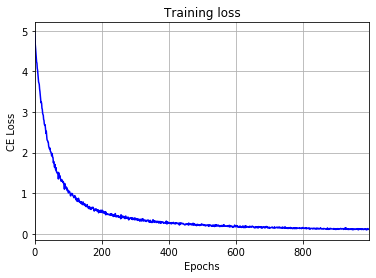

In [35]:
# plot training loss
plt.plot(loss_his, label='training loss', color='blue')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Training loss')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### Validation Loss

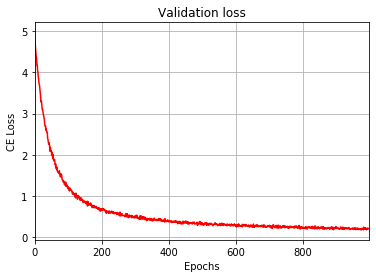

In [36]:
# plot validation loss
plt.plot(loss_val_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Validation loss')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### Zoom at the minimum of CE loss curve

Epoch with minimum validation loss = 976


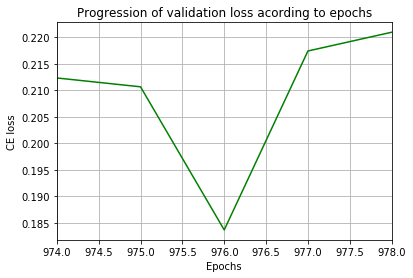

In [37]:
best_epoch = loss_val_his.index(min(loss_val_his)) + 1
print('Epoch with minimum validation loss =', best_epoch)
#-------------------------------------------------
# plots
plt.plot(range(max(1,best_epoch-2),min(EPOCH,best_epoch+3)), loss_val_his[max(1,best_epoch-3):min(EPOCH-1,best_epoch+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('CE loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of validation loss acording to epochs')
plt.grid(True)
plt.show()

### Final metrics values:

In [38]:
print('last training loss = {0:.4f}'.format(loss_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_val_his[-1]))
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train.item()))
print('last validation accuracy = {0:.4f}'.format(acc_val.item()))

last training loss = 0.1326
last validation loss = 0.2191
#-------------------------------------------------
last train accuracy = 0.9975
last validation accuracy = 0.9766


### Function to plot confusion matrix

In [0]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    #heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Confusion Matrix

In [0]:
y_pred = np.array(y_pred_final)
y_true = np.array(ds_test.targets)
cm = confusion_matrix(y_true, y_pred)
classes = np.asarray(ds_test.classes)

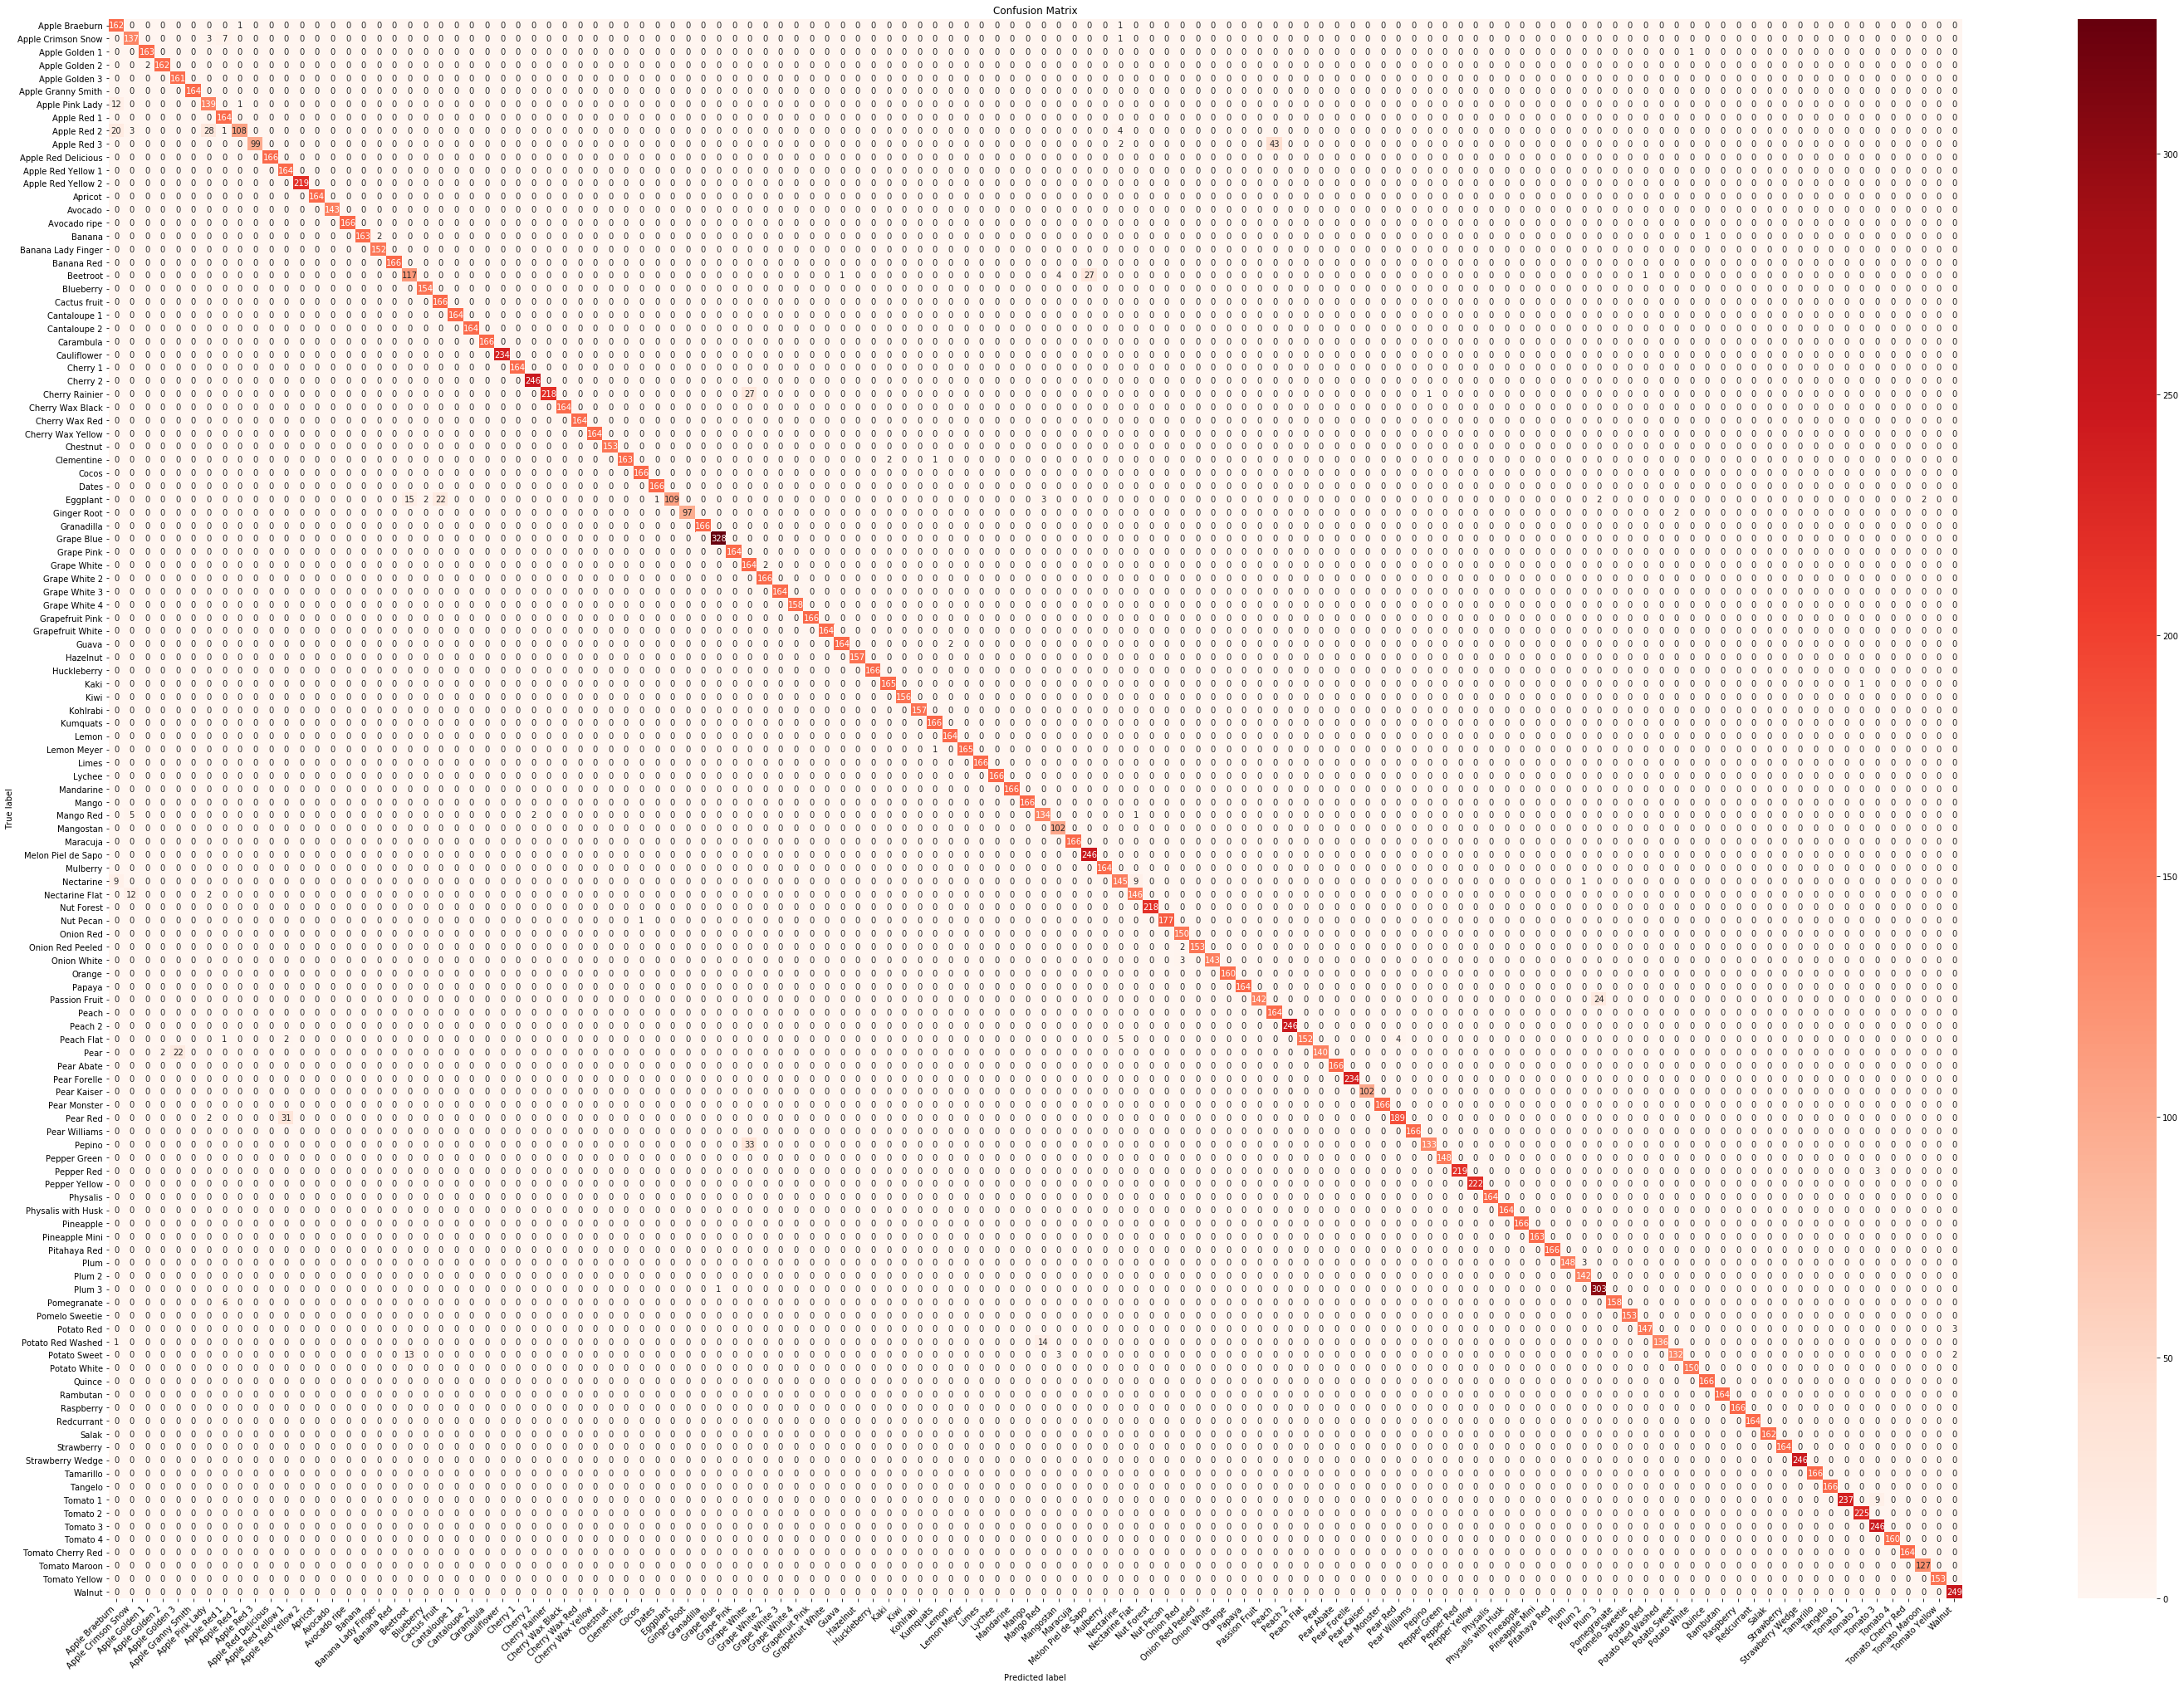

In [41]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, figsize = (50,35), cmap=plt.cm.Reds, fontsize=10)

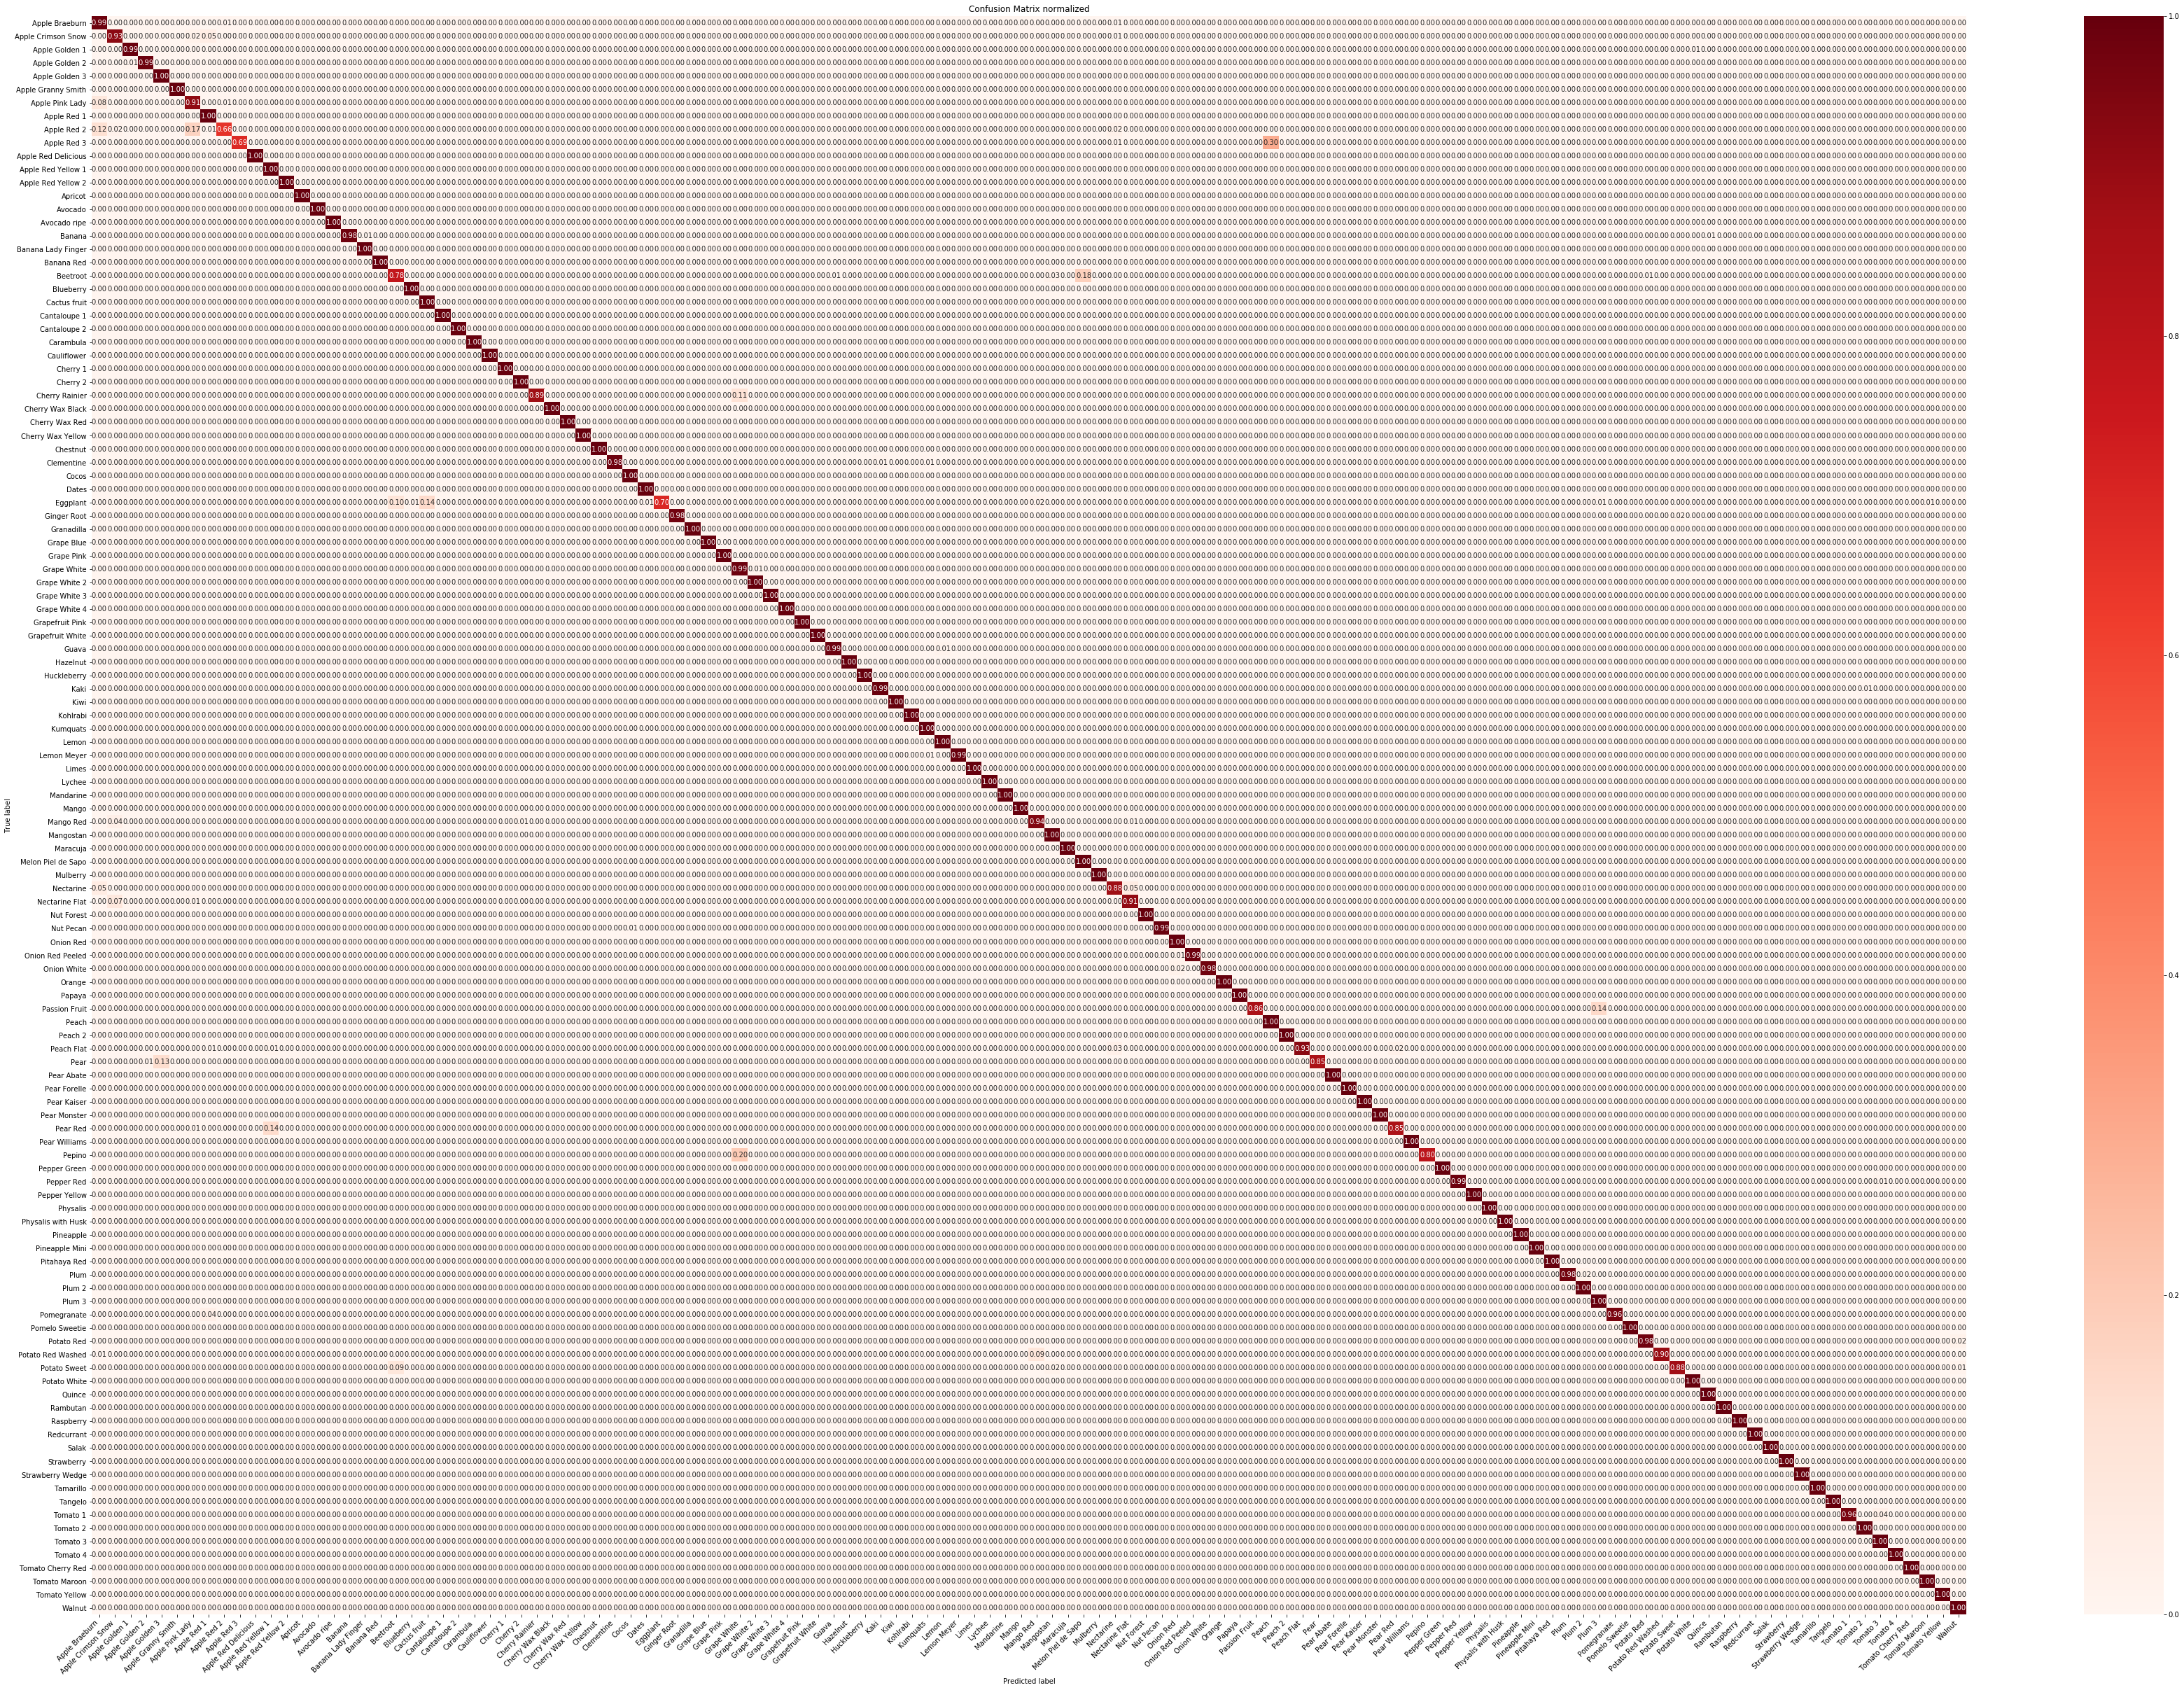

In [42]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, figsize = (60,42), cmap=plt.cm.Reds, fontsize=10)

### F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [44]:
print('F1-score macro =', macro)
print('F1-score micro =', micro)
print('F1-score weighted =', weighted)

F1-score macro = 0.9755375572061631
F1-score micro = 0.9765784114052953
F1-score weighted = 0.9763139808367246


### Accuracy and Precision

In [0]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')

In [46]:
print('Accuracy score = ', acc, sep='')
print('Precision score = ', prec, sep='')

Accuracy score = 0.9765784114052953
Precision score = 0.9787807017906187


### Precision, Recall and F1-Score for each class

In [47]:
from sklearn.metrics import classification_report as cr
print(cr(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       164
           1       0.87      0.93      0.90       148
           2       0.99      0.99      0.99       164
           3       0.99      0.99      0.99       164
           4       0.88      1.00      0.94       161
           5       1.00      1.00      1.00       164
           6       0.80      0.91      0.85       152
           7       0.92      1.00      0.96       164
           8       0.98      0.66      0.79       164
           9       1.00      0.69      0.81       144
          10       1.00      1.00      1.00       166
          11       0.83      1.00      0.91       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       1.00      1.00      1.00       143
          15       1.00      1.00      1.00       166
          16       1.00      0.98      0.99       166
          17       0.99    

### Saving model parameters for fine tunning (project part III)

In [0]:
#torch.save(resnet34.state_dict(), 'resnet34_state_dict.pt')
torch.save(model.state_dict(), 'model_state_dict.pt')

In [0]:
# # Loading model
# import torchvision.models as models
# resnet34 = models.resnet34(pretrained=True)
# resnet34.fc = torch.nn.Identity(in_features=512, out_features=120)
# resnet34.load_state_dict(torch.load('model_state_dict.pt'))
# resnet34.eval()